# Linear Prediction
In this lab, we will learn how to use linear prediction methods
to estimate continuous outcomes, and to evaluate the 
quality of competing models. We will explore both 
the 

# Predicting Loan Quality

One of the most imporant aspects of lending is determining the
interest rate to give a customer. Set rates too high, and the
customer may choose another lender. Set rates too low, and 
lender may not earn enough interest to offset defaults and other expenses.

The data for this exercise comes from Lending Club, a peer-to-peer lending company.
They facilitate loans and allow individuals to make loans or borrow money (you 
can read more about them on 
[Wikipedia](https://en.wikipedia.org/wiki/Lending_Club).

We can get historical data from the
[Lending Club data page](https://www.lendingclub.com/info/download-data.action).

Download the loan data that is on Blackboard. This is not the newest data, 
but it has the outcomes of many loans that have reached maturity. We can use the first dataset
to train and the second to test. You should also download the data dictionary. 

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import metrics

## Preprocessing

First, let's view some of the columns in dataframe.

In [4]:
ld = pd.read_csv('data/lendingclub_2015-2018.csv')
ld.head()
tmp = ld.tail()
display(tmp)

/var/folders/ll/5fnyw07s0p74sdfnrqqwwhgc0000gn/T/ipykernel_67882/177355301.py:1: DtypeWarning: Columns (20,60,119,130,131,132,135,136,137,140,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  ld = pd.read_csv('data/lendingclub_2015-2018.csv')


,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,duration
249990,249991,145635719,NaN,35000.0,35000.0,35000.0,60 months,18.94,906.77,D,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,60
249991,249992,145635974,NaN,7500.0,7500.0,7500.0,36 months,10.72,244.55,B,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36
249992,249993,145637006,NaN,30000.0,30000.0,30000.0,60 months,27.27,920.91,E,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,60
249993,249994,145641258,NaN,22650.0,22650.0,22650.0,36 months,10.72,738.54,B,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36
249994,249995,145642272,NaN,1000.0,1000.0,1000.0,36 months,18.94,36.63,D,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36


### Interest Rate
Since we are interested in the interest rates that customers receive, let's plot a histogram to see how rates are distributed.

<AxesSubplot:>

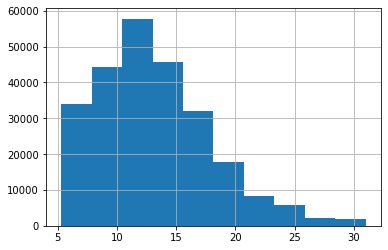

In [5]:
ld['int_rate'].hist()

### Loan Duration
The loan duration column is formatted as a text string, and must be cleaned up for analysis.

In [6]:
# view unique values
ld['term'].unique()

# split rows into parts
term_split = ld['term'].str.split(' ')

# view first five rows
print(term_split[:5])

0    [, 36, months]
1    [, 36, months]
2    [, 36, months]
3    [, 36, months]
4    [, 36, months]
Name: term, dtype: object


In [7]:
# the str function can retrieve a specific list element for all rows
term_split.str[1]
ld['duration'] = term_split.str[1]

# add this to the dataframe
display(ld['duration'].head())
# this column is not in integer format. Must fix!

0    36
1    36
2    36
3    36
4    36
Name: duration, dtype: object

In [8]:
# convert column to integer
ld['duration'] = ld['duration'].apply(int)
display(ld['duration'].head())

0    36
1    36
2    36
3    36
4    36
Name: duration, dtype: int64

### Rescaling
Some of the columns that we will use are on very different scales. For example, loan amount and annual income range from 0 to tens of thousands of dollars,
whereas the debt-to-income (`dti`) range is much smaller. This can cause issues when fitting the models.

We will transform the income and loan amount variables using a log transformation.


In [9]:
ld['log_loan_amnt'] = np.log(ld['loan_amnt'])
ld['log_annual_inc'] = np.log(ld['annual_inc']+1)

### Correlations
Let's run some correlations to see how some columns relate to one another

In [10]:
cols = ['int_rate', 'log_loan_amnt', 'installment', 'log_annual_inc', 'duration', 'fico_range_low', 'revol_util', 'dti']
corr = ld[cols].corr()
corr.style.background_gradient(cmap='coolwarm')

# ld[cols].corr() # <--- use this if you just want the table in non-graphical format

,int_rate,log_loan_amnt,installment,log_annual_inc,duration,fico_range_low,revol_util,dti
int_rate,1.000000,0.083863,0.123667,-0.109038,0.373178,-0.415338,0.262690,0.119422
log_loan_amnt,0.083863,1.000000,0.877808,0.379664,0.413820,0.087016,0.108325,0.045102
installment,0.123667,0.877808,1.000000,0.385775,0.142060,0.053882,0.122495,0.042640
log_annual_inc,-0.109038,0.379664,0.385775,1.000000,0.100023,0.062736,0.068547,-0.240150
duration,0.373178,0.413820,0.142060,0.100023,1.000000,0.009706,0.068505,0.057225
fico_range_low,-0.415338,0.087016,0.053882,0.062736,0.009706,1.000000,-0.476191,-0.025385
revol_util,0.262690,0.108325,0.122495,0.068547,0.068505,-0.476191,1.000000,0.112625
dti,0.119422,0.045102,0.042640,-0.240150,0.057225,-0.025385,0.112625,1.000000


Of these values, interest rate has the strongest correlations with duration and FICO score. The correlation between loan amount
and installment size is quite high, so we should drop one of these from our subsequent analysis (highly correlated variables can 
cause issues with linear regression).

Create a list of the variables to use for the prediction of interest rate:

In [11]:
pred_vars = ['log_loan_amnt', 'log_annual_inc', 'fico_range_low', 'revol_util', 'dti', 'duration']

### Drop rows with missing values

There are some rows in this dataframe that are missing values for at least one of our predictor columns.
We will drop these from the dataframe before proceeding to avoid downstream errors.

In [12]:
print("before dropping rows with missing data", len(ld))
ld = ld.dropna(subset=pred_vars)
print("after dropping rows with missing data", len(ld))

before dropping rows with missing data 249995
after dropping rows with missing data 249582


We now have a dataset that is cleaned and ready for analysis.

# Training and testing sets
With this dataset, the observations are ordered from newest to oldest. We can 
simulate a real-world situation by splitting our data into train and test subsets
by their position in the series. 

In [13]:
from sklearn.model_selection import train_test_split

# use index-based sampling since we have time series data
train, test = train_test_split(ld, test_size=0.25, shuffle=False)

Now, view the start and end dates for the two samples:

In [15]:
# earliest and latest dates in train
print("training data starts\n", train['issue_d'].head())
print("training data ends\n", train['issue_d'].tail())
# earliest and latest in test
print("testing data starts\n", test['issue_d'].head())
print("testing data ends\n", test['issue_d'].tail())

training data starts
 0    Jul-2007
1    Jul-2007
2    Jul-2007
3    Jul-2007
4    Jul-2007
Name: issue_d, dtype: object
training data ends
 187369    Nov-2017
187370    Nov-2017
187371    Nov-2017
187372    Nov-2017
187373    Nov-2017
Name: issue_d, dtype: object
testing data starts
 187374    Nov-2017
187375    Nov-2017
187376    Nov-2017
187377    Nov-2017
187378    Nov-2017
Name: issue_d, dtype: object
testing data ends
 249990    Dec-2018
249991    Dec-2018
249992    Dec-2018
249993    Dec-2018
249994    Dec-2018
Name: issue_d, dtype: object


# Simple Linear Regression

The syntax for creating models using the `statsmodels` package
is similar to that of `sklearn` (`sklearn` has linear regression
functions, but it is somewhat barebones in it's model summaries
compared to `statsmodels`). The documentation for 
ordinary least squares (OLS) regression using
`statsmodels` is 
[here](https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS).

Predict the interest rate as a function of credit score
`fico_range_low`. This variable has the strongest correlation
with interest rate from those in our correlation table.

In [16]:
reg_fico = sm.OLS(train['int_rate'], train['fico_range_low']).fit()
reg_fico.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               int_rate   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.873
Method:                 Least Squares   F-statistic:                          1.287e+06
Date:                Thu, 20 Oct 2022   Prob (F-statistic):                        0.00
Time:                        00:34:31   Log-Likelihood:                     -5.6714e+05
No. Observations:              187186   AIC:                                  1.134e+06
Df Residuals:                  187185   BIC:                                  1.134e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
fico_range_low     0.0188   1.66e-05   1134.408      0.000       0.019       0.019
==============================================================================
Omnibus:                    10997.634   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13259.038
Skew:                           0.605   Prob(JB):                         0.00
Kurtosis:                       3.483   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, add additional predictors from our list from earlier. 

## Add additional variables
Next, build a regression using the variables in the list of `pred_vars`. 

In [17]:
reg_multi = sm.OLS(train['int_rate'], train[pred_vars], hasconst=False).fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               int_rate   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.909
Method:                 Least Squares   F-statistic:                          3.135e+05
Date:                Thu, 20 Oct 2022   Prob (F-statistic):                        0.00
Time:                        00:34:34   Log-Likelihood:                     -5.3544e+05
No. Observations:              187186   AIC:                                  1.071e+06
Df Residuals:                  187180   BIC:                                  1.071e+06
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
log_loan_amnt      0.4867      0.018     27.573      0.000       0.452       0.521
log_annual_inc     0.4736      0.019     25.196      0.000       0.437       0.510
fico_range_low    -0.0094      0.000    -38.372      0.000      -0.010      -0.009
revol_util         0.0350      0.000     79.704      0.000       0.034       0.036
dti                0.0454      0.001     52.977      0.000       0.044       0.047
duration           0.1685      0.001    169.180      0.000       0.167       0.170
==============================================================================
Omnibus:                    20040.090   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33725.942
Skew:                           0.755   Prob(JB):                         0.00
Kurtosis:                       4.429   Cond. No.                     1.62e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This new model performs better on out of sample data.

# Evaluation

For OLS, the $R^2$ of a model is often the statistic that people look at first. This 
describes the amount of variance in $Y$ that is explained by the predictors. It will always
increase with additional predictor variables, so we will want to look at some additional measures that penalize 
having too many predictors in the model.

One measure is the Adjusted $R^2$, which considers the number of variables in the model. For large samples, this
is essentially the same as $R^2$. Two measures that consider both the number of variables *and* the quality
of the model are Akaike's Information Criterion (AIC) and Bayesian Information Criterion (BIC). These values
do not have much significance on their own, like $R^2$, but they are very good for comparing models. Lower 
values of AIC or BIC are better.

Which model has the lowest AIC?

In [18]:
print(reg_fico.aic)
print(reg_multi.aic)

1134288.3080747342
1070889.1563837891


In [19]:
print(reg_fico.bic)
print(reg_multi.bic)

1134298.4479327882
1070949.9955321127


Another comparison method is to use an ANOVA. This compares models for statistically significant
improvements. A $p$-value less than $0.05$ is generally considered a significant improvement.
This method can determine if the addition of variables improves the model.

In [20]:
sm.stats.anova_lm(reg_fico, reg_multi)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,187185.0,4.693344e+06,0.0,NaN,NaN,NaN
1,187180.0,3.344763e+06,5.0,1.348581e+06,15093.884858,0.0


## Prediction
To further evaluate the quality of these models, we will look at out-of-sample prediction
with the test data. We will use the root mean squared error (RMSE) to evaluate 
the performance of this model. Lower values indicate smaller prediction errors and
a better model. 

First, get the predictions from the model that only uses FICO.

In [21]:
fico_pred = reg_fico.predict(test['fico_range_low'])

fico_rmse = metrics.mean_squared_error(test['int_rate'], fico_pred, squared=False)
print("RMSE:", fico_rmse)

RMSE: 5.4935559541762


Then do the same for the model using multiple predictors.

In [22]:
multi_pred = reg_multi.predict(test[pred_vars])

multi_rmse = metrics.mean_squared_error(test['int_rate'], multi_pred, squared=False)
print("RMSE:", multi_rmse)

RMSE: 4.706613506113942


The second model performs better on out of sample data. 

# Summary
We built regression models in an attempt to predict interest rates for loans from Lending Club
using data about the loan request and borrower information. First, we cleaned and transformed the
data, then viewed the correlations between a subset of variables. Then, we built models on
on a training set of data and compared model fit measures (AIC, BIC, ANOVA). Lastly, we compared
the models on a holdout set of data.

# Exercises
1. Can you build a model that performs significantly better than the models 
   already built? Train the model and compare it. Which variables did you 
   use and why do you think they improved the model? Provide the statistics you used 
   to evaluate. 

   I used 'loan_amnt', 'inq_last_6mths', 'int_rate', 'bc_util', 'log_last_pymnt_amnt' 
             ,'duration' and this did not improve pver the lab my aic is -11163604.188716834 and my rsme is 9.91286636332359e-15

   **Do not use the `installment` column.**
   
2. What level of RMSE would you consider acceptable would you consider appropriate in this situation? Provide justification for your answer.

i would say a 3 because so far the closest we got was a 4 so a three would mean we've gotten closer to the interest rate

In [23]:
sd = pd.read_csv('data/lendingclub_2015-2018.csv')
sd.head()
tmp = sd.tail()
display(tmp)

/var/folders/ll/5fnyw07s0p74sdfnrqqwwhgc0000gn/T/ipykernel_67882/177355301.py:1: DtypeWarning: Columns (20,60,119,130,131,132,135,136,137,140,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  ld = pd.read_csv('data/lendingclub_2015-2018.csv')


,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,duration
249990,249991,145635719,NaN,35000.0,35000.0,35000.0,60 months,18.94,906.77,D,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,60
249991,249992,145635974,NaN,7500.0,7500.0,7500.0,36 months,10.72,244.55,B,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36
249992,249993,145637006,NaN,30000.0,30000.0,30000.0,60 months,27.27,920.91,E,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,60
249993,249994,145641258,NaN,22650.0,22650.0,22650.0,36 months,10.72,738.54,B,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36
249994,249995,145642272,NaN,1000.0,1000.0,1000.0,36 months,18.94,36.63,D,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36


In [24]:
# view unique values
sd['term'].unique()

# split rows into parts
term_split = sd['term'].str.split(' ')

# view first five rows
print(term_split[:5])

0    [, 36, months]
1    [, 36, months]
2    [, 36, months]
3    [, 36, months]
4    [, 36, months]
Name: term, dtype: object


In [33]:
# the str function can retrieve a specific list element for all rows
term_split.str[1]
sd['duration'] = term_split.str[1].apply(int)

# add this to the dataframe
display(ld['duration'].head())

sd['log_funded_amnt'] = np.log(sd['funded_amnt'])
sd['log_last_pymnt_amnt'] = np.log(sd['last_pymnt_amnt']+1)

pred_vars = ['loan_amnt', 'inq_last_6mths', 'int_rate', 'bc_util', 'log_last_pymnt_amnt' 
             ,'duration']
             

167    36
274    36
323    36
375    36
379    36
Name: duration, dtype: int64

In [34]:
print("before dropping rows with missing data", len(sd))
sd = sd.dropna(subset=pred_vars)
print("after dropping rows with missing data", len(sd))

before dropping rows with missing data 241305
after dropping rows with missing data 241305


In [35]:
train, test = train_test_split(sd, test_size=0.25, shuffle=False)

In [36]:
reg_multi = sm.OLS(train['int_rate'], train[pred_vars], hasconst=False).fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               int_rate   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.282e+34
Date:                Thu, 20 Oct 2022   Prob (F-statistic):                        0.00
Time:                        00:40:17   Log-Likelihood:                      5.5818e+06
No. Observations:              180978   AIC:                                 -1.116e+07
Df Residuals:                  180972   BIC:                                 -1.116e+07
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt            5.184e-19   2.93e-21    177.218      0.000    5.13e-19    5.24e-19
inq_last_6mths      -7.772e-15   2.63e-17   -295.599      0.000   -7.82e-15   -7.72e-15
int_rate                1.0000   5.57e-18    1.8e+17      0.000       1.000       1.000
bc_util             -6.245e-17   8.17e-19    -76.456      0.000   -6.41e-17   -6.08e-17
log_last_pymnt_amnt  5.135e-16   1.06e-17     48.493      0.000    4.93e-16    5.34e-16
duration             1.058e-16   2.16e-18     49.016      0.000    1.02e-16     1.1e-16
==============================================================================
Omnibus:                    15683.169   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22711.903
Skew:                           0.695   Prob(JB):                         0.00
Kurtosis:                       4.038   Cond. No.                     1.99e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
print(reg_multi.aic)

-11163604.188716834


In [40]:
multi_pred = reg_multi.predict(test[pred_vars])

multi_rmse = metrics.mean_squared_error(test['int_rate'], multi_pred, squared=False)
print( multi_rmse)

9.91286636332359e-15
